In [15]:
from anchor import utils
from anchor import anchor_tabular
import pandas as pd
import sklearn.ensemble
import numpy as np
from anchor import anchor_tabular
import os

In [16]:
feature_names = None
features_to_use = [2, 4, 5, 6, 7, 9]
categorical_features = [2, 4, 7]

target_idx = 1
dataset_folder = train_path = "../../../datasets/titanic/"
discretize = True
balance = True

def filter_fn(data):
  df = pd.DataFrame(data)

  df.dropna(inplace=True)
  ###
  return df.values.astype('|S128')

dataset = utils.load_csv_dataset(
            os.path.join(dataset_folder, 'train.csv'), target_idx, ',',
            feature_names=feature_names, features_to_use=features_to_use,
            categorical_features=categorical_features, discretize=discretize,
            balance=balance, filter_fn = filter_fn, skip_first=True)

In [17]:
print(dataset.train[0])

[0. 0. 1. 2. 2. 3.]


In [18]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
#print(np.unique(dataset.labels_train))
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 0.8921389396709324
Test 0.9420289855072463


In [19]:
transformed_data = []

for r in dataset.train:
    transformed_data.append([dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(r)])        

print(transformed_data[0])

train_data = pd.DataFrame(transformed_data, columns=dataset.feature_names)
print(train_data.shape)
nb_vals = 100

print(dataset.train[0])
print(dataset.train[0].reshape(1, -1))
y=[]
for k in range(0, nb_vals):
    y.append(c.predict(dataset.train[k].reshape(1, -1))[0])


['1', 'female', '6.00 < Age <= 24.00', 'SibSp > 1.00', '2', 'Fare > 31.00']
(547, 6)
[0. 0. 1. 2. 2. 3.]
[[0. 0. 1. 2. 2. 3.]]


In [20]:
import sys
sys.path.append(sys.path[0] + '/../..')

import arg_explainer as ae
from importlib import reload
reload(ae)
import arg_explainer as ae

print(dataset.feature_names)
explainer = ae.ArgTabularExplainer(c, train_data.iloc[0:nb_vals], y, 'titanic_' + str(nb_vals), compute=False, output_path='../../saves')

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


In [21]:
G = explainer.build_attack_graph(compute=False, display_graph=False)
print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))
print('nodes:', len(G.nodes()))

explainer.export_graph('asp', '../../saves')

edges per node: 40.33898305084746
nodes: 118


[1415, 317, 2306, 1552, 1415]
(25, 50, 75, 491, 1386) (42, 92, 116, 351, 351)


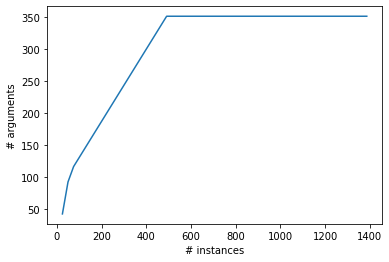

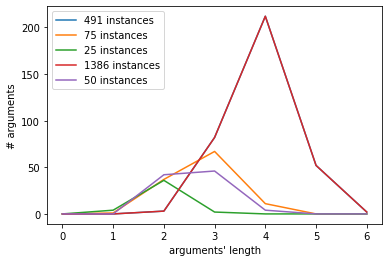

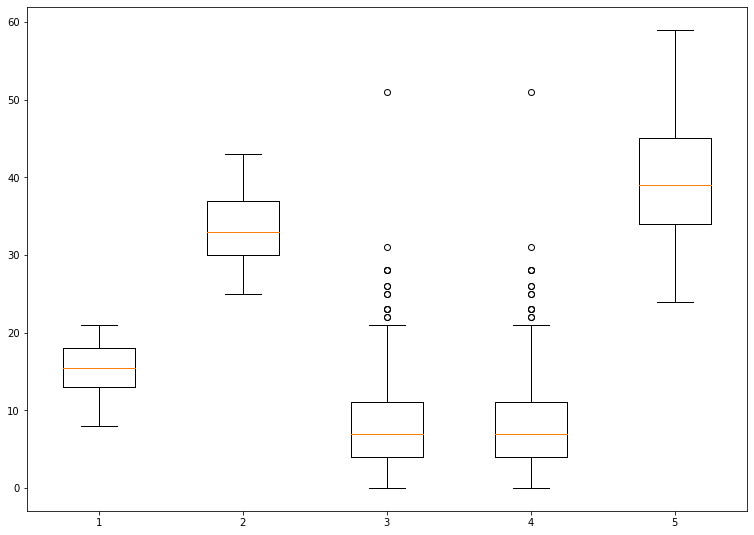

(1386, 491, 75, 50, 25) (0.09401709401709402, 0.09401709401709402, 0.0, 0.0, 0.0)


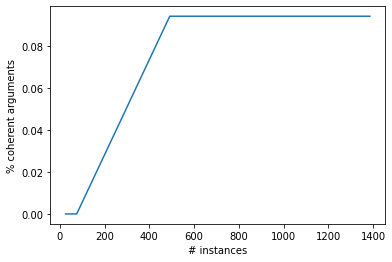

In [22]:
explainer.af_analysis(remove=['100', '200','300', '400', '500', '600', '700', '800'])
#explainer.af_analysis(remove=['synth'])

In [35]:
from typing import OrderedDict
import networkx as nx
from sklearn import preprocessing
import random
from itertools import combinations

le = preprocessing.LabelEncoder()
#print(explainer.categorical_names)
#print(explainer.categorical_features)
#print(explainer.ordinal_features)
#le.set_params(explainer.feature_names)

def generate_full_dataset():
    instance = OrderedDict.fromkeys(explainer.dataset.columns)
    full_dataset = []
    def gen_rec(instance, columns, col_index, full_dataset):
        inst_ = instance.copy()
        if col_index == len(columns) - 1:
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                full_dataset.append(list(inst_.values()))
        else:
            inst_ = instance.copy()
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                gen_rec(inst_, columns, col_index + 1, full_dataset)

    gen_rec(instance, list(instance.keys()), 0, full_dataset)
    return full_dataset

def generate_full_neighborhood(origin, depth):
    #instance = OrderedDict.fromkeys(explainer.dataset.columns)
    instance = origin.copy()
    nbh_list = []

    def gen_rec(cols_, nbh_list):
        nbhs = []
        for nbh in nbh_list:
            for f in explainer.features_p_col[cols_[0]]:
                # create a new instance with each value for the column
                current_value = explainer.feature_names[f][len(cols_[0])+1:]
                if current_value != origin[cols_[0]]:
                    inst_ = nbh.copy()
                    inst_[cols_[0]] = current_value
                    nbhs.append(inst_)
        if len(cols_) > 1:
            nbhs = gen_rec(cols_[1:], nbhs)
        return nbhs
                
    for cols_ in combinations(list(instance.keys()), depth):
        nbh_list += gen_rec(cols_, [instance])
    nlist = []
    for nbh in nbh_list:
        nlist.append(list(nbh.values()))
    return nlist

def generate_instance_random(constraints):
    instance = OrderedDict.fromkeys(explainer.dataset.columns)
    for f in constraints:
        col=explainer.col_p_feature[f]
        instance[col] = explainer.feature_names[f].split('_')[1]
        fill_instance(instance, 'random')
    return list(instance.values())

def fill_instance(instance, strategy):
    if strategy == 'random':
        # fill the instance with a random values sampled from baseline dataset
        for i_, col in enumerate(instance.keys()):
            if instance[col] is None:
                instance[col] = explainer.dataset[col].sample(1, random_state=1).values[0]
    elif strategy == 'most_frequent':
        # fill the instance with the most frequent value for each column
        for k, i_ in enumerate(instance.keys()):
            if instance[k] is None:
                instance[k] = explainer.dataset[i_].value_counts().index[0]
    
def instance2encoded(instance, dataset):
    encoded = []
    for col in dataset.categorical_features:
        encoded.append(dataset.categorical_names[col].index(instance[col]))
    return np.array(encoded)

def extend_dataset(G, dataset_t, y_t):
    # attackers = []
    # print(G.degree)
    # for v, deg in G.degree:
    #     if deg > 0:
    #         attackers += G.edges(v)
    # print('len attackers:', len(attackers))
    # print(attackers[0])
    # # predict new data
    # transformed_data_plus = []
    # y_plus = []
    # print("Generating " + str(len(attackers)) + " new data...")
    # addition_set = set([tuple(i) for i in dataset_t])
    # for a in attackers:
    #     # print(a, [explainer.feature_names[k] for k in a[1]])
    #     inst = generate_instance_random(set.union(set(a[0]), set(a[1])))
    #     if tuple(inst) not in addition_set:
    #         addition_set.add(tuple(inst))
    #         transformed_data_plus.append(inst)
    #         y_plus.append(c.predict(instance2encoded(inst, dataset).reshape(1, -1))[0])
    # print(str(len(transformed_data_plus)) + " instances added")
    # print(str(len(y_plus)) + " instances predicted")

    full_dataset = generate_full_dataset()
    transformed_data_plus = full_dataset
    encoded_data_plus = [c.predict(instance2encoded(i_, dataset).reshape(1,-1))[0] for i_ in full_dataset]
    y_plus = encoded_data_plus
    train_data_plus = train_data = pd.DataFrame(transformed_data[:nb_vals] + transformed_data_plus, columns=dataset.feature_names)
    
    dataset_t += transformed_data_plus
    y_t += y_plus
    print('total length', len(dataset_t), len(y_t))
    train_data_plus = pd.DataFrame(dataset_t, columns=dataset.feature_names)
    #print(train_data_plus.shape)
    #print(y_plus)
    explainer = ae.ArgTabularExplainer(c, train_data_plus, y_t, 'adult_' + str(nb_vals) + '_extended', compute=True, output_path='../saves')

    G = explainer.build_attack_graph(compute=True, display_graph=True)
    print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))
    return G, dataset_t, y_t

def explore_full_dataset(nb_steps):
    full_dataset = generate_full_dataset()
    y_plus = [c.predict(instance2encoded(i_, dataset).reshape(1,-1))[0] for i_ in full_dataset]
    #train_data_plus = train_data = pd.DataFrame(transformed_data[:nb_vals] + transformed_data_plus, columns=dataset.feature_names)
    
    random.seed(1)
    indices = list(range(len(full_dataset)))
    random.shuffle(indices)
    full_dataset_shuff = [full_dataset[i] for i in indices] 
    y_plus_shuff = [y_plus[i] for i in indices]

    print(np.unique(np.array(y_plus_shuff)))
    
    step_len = len(full_dataset)//nb_steps
    steps = [i*step_len for i in range(1, nb_steps)]
    steps.append(len(full_dataset))
    for nb_vals in steps:
        dataset_t = full_dataset_shuff[:nb_vals]
        y_t = y_plus_shuff[:nb_vals]
        print('total length', len(dataset_t), len(y_t))
        train_data_plus = pd.DataFrame(dataset_t, columns=dataset.feature_names)

        explainer = ae.ArgTabularExplainer(c, train_data_plus, y_t, 'titanic_' + str(nb_vals) + '_synth', compute=True, output_path='../saves')

        G = explainer.build_attack_graph(compute=True, display_graph=False)
        print('total args:', len(G.nodes()))
        print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))


def data2origin(instance):
    origin = OrderedDict.fromkeys(explainer.dataset.columns)
    for k, v in zip(explainer.dataset.columns, instance):
        #print(k, v, explainer.features_p_col[k])
        fk = list(explainer.features_p_col[k])[int(v)] # feature key in features_p_col
        origin[k] = explainer.feature_names[fk][len(str(k))+1:]
    return origin


def remove_duplicates(list_):
    new_list = []
    for i in list_:
        if i not in new_list:
            new_list.append(i)
    print('duplicates', len(list_)-len(new_list))
    return new_list


def generate_neighborhoods(dataset, depth):
    nbh_dataset = []
    print('Generating ' + str(len(y)) + ' neighborhoods...')
    for inst_ in dataset:
        try:
            origin = data2origin(inst_)
            nbh_dataset += generate_full_neighborhood(origin, depth)
        except:
            print('error', inst_)
    return nbh_dataset

def explore_neighborhoods(nb_steps):
    
    origin_dataset = dataset.train[:len(y)]
    nbh_dataset = []
    random.seed(1)
    
    # set up experiments datasets length
    len_max = len(generate_full_dataset())
    print('len_max', len_max)
    step_len =  len_max // nb_steps
    steps = [i*step_len for i in range(1, nb_steps)]
    steps.append(len_max)
    print(steps)
    
    depth = 0
    for nb_vals in steps:
        #generate nbh dataset with enough data
        while len(nbh_dataset) < nb_vals:
            print(len(nbh_dataset), nb_vals)
            depth += 1
            nbh_dataset += generate_neighborhoods(origin_dataset, depth)
            nbh_dataset = remove_duplicates(nbh_dataset)
    
        y_plus = [c.predict(instance2encoded(i_, dataset).reshape(1,-1))[0] for i_ in nbh_dataset]
        #train_data_plus = train_data = pd.DataFrame(transformed_data[:nb_vals] + transformed_data_plus, columns=dataset.feature_names)

        
        indices = list(range(len(nbh_dataset)))
        random.shuffle(indices)
        nbh_dataset_shuff = [nbh_dataset[i] for i in indices] 
        y_plus_shuff = [y_plus[i] for i in indices]

        print(np.unique(np.array(y_plus_shuff)))

        dataset_t = nbh_dataset_shuff[:nb_vals]
        y_t = y_plus_shuff[:nb_vals]
        print('total length', len(dataset_t), len(y_t))
        train_data_plus = pd.DataFrame(dataset_t, columns=dataset.feature_names)

        explainer = ae.ArgTabularExplainer(c, train_data_plus, y_t, 'titanic_' + str(nb_vals) + '_synth_nbh', compute=True, output_path='../../saves')

        G = explainer.build_attack_graph(compute=True, display_graph=False)
        print('total args:', len(G.nodes()))
        print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))

#explore_full_dataset(16)
explore_neighborhoods(16)

len_max 1152
[72, 144, 216, 288, 360, 432, 504, 576, 648, 720, 792, 864, 936, 1008, 1080, 1152]
0 72
Generating 100 neighborhoods...
error [2. 0. 3. 0. 5. 2.]
duplicates 895
[0 1]
total length 72 72
Generating arguments
len  1 : 0 ,  0
20 potential arg checked ( 0 not minimal)
len  2 : 16 ,  15
160 potential arg checked ( 0 not minimal)
len  3 : 72 ,  74
358 potential arg checked ( 210 not minimal)
len  4 : 19 ,  11
122 potential arg checked ( 640 not minimal)
len  5 : 0 ,  0
9 potential arg checked ( 386 not minimal)
len  6 : 0 ,  0
0 potential arg checked ( 72 not minimal)
Saving to  ../../saves/titanic_72_synth_nbh_minimals.df
titanic_72_synth_nbh
total args: 207
edges per node: 21.864734299516908
[0 1]
total length 144 144
Generating arguments
len  1 : 0 ,  0
20 potential arg checked ( 0 not minimal)
len  2 : 6 ,  8
165 potential arg checked ( 0 not minimal)
len  3 : 79 ,  76
531 potential arg checked ( 132 not minimal)
len  4 : 56 ,  32
350 potential arg checked ( 760 not minimal)

len  5 : 54 ,  52
890 potential arg checked ( 1317 not minimal)
len  6 : 4 ,  1
5 potential arg checked ( 1075 not minimal)
Saving to  ../../saves/titanic_1080_synth_nbh_minimals.df
titanic_1080_synth_nbh
total args: 284
edges per node: 0.7746478873239436
[0 1]
total length 1152 1152
Generating arguments
len  1 : 0 ,  0
20 potential arg checked ( 0 not minimal)
len  2 : 0 ,  1
165 potential arg checked ( 0 not minimal)
len  3 : 10 ,  22
703 potential arg checked ( 15 not minimal)
len  4 : 78 ,  62
1407 potential arg checked ( 329 not minimal)
len  5 : 34 ,  32
919 potential arg checked ( 1289 not minimal)
len  6 : 4 ,  3
7 potential arg checked ( 1145 not minimal)
Saving to  ../../saves/titanic_1152_synth_nbh_minimals.df
titanic_1152_synth_nbh
total args: 246
edges per node: 0.0


In [ ]:
from typing import OrderedDict
import networkx as nx
from sklearn import preprocessing
import random
from numba import njit

le = preprocessing.LabelEncoder()


def generate_full_dataset():
    instance = OrderedDict.fromkeys(explainer.dataset.columns)
    full_dataset = []

    def gen_rec(instance, columns, col_index, full_dataset):
        inst_ = instance.copy()
        if col_index == len(columns) - 1:
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                full_dataset.append(list(inst_.values()))
        else:
            inst_ = instance.copy()
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                gen_rec(inst_, columns, col_index + 1, full_dataset)

    gen_rec(instance, list(instance.keys()), 0, full_dataset)
    return full_dataset

def instance2encoded(instance, dataset):
    encoded = []
    for col in dataset.categorical_features:
        encoded.append(dataset.categorical_names[col].index(instance[col]))
    return np.array(encoded)

def explore_full_dataset(nb_steps):
    full_dataset = generate_full_dataset()
    y_plus = [c.predict(instance2encoded(i_, dataset).reshape(1,-1))[0] for i_ in full_dataset]
    #train_data_plus = train_data = pd.DataFrame(transformed_data[:nb_vals] + transformed_data_plus, columns=dataset.feature_names)
    
    random.seed(1)
    indices = list(range(len(full_dataset)))
    random.shuffle(indices)
    full_dataset_shuff = [full_dataset[i] for i in indices] 
    y_plus_shuff = [y_plus[i] for i in indices]

    print(np.unique(np.array(y_plus_shuff)))
    
    step_len = len(full_dataset)//nb_steps
    steps = [i*step_len for i in range(1, nb_steps)]
    steps.append(len(full_dataset))
    for nb_vals in steps:
        dataset_t = full_dataset_shuff[:nb_vals]
        y_t = y_plus_shuff[:nb_vals]
        print('total length', len(dataset_t), len(y_t))
        train_data_plus = pd.DataFrame(dataset_t, columns=dataset.feature_names)

        explainer = ae.ArgTabularExplainer(c, train_data_plus, y_t, 'titanis_' + str(nb_vals) + '_synth', compute=False, output_path='../../saves')

        G = explainer.build_attack_graph(compute=False, display_graph=False)
        print('total args:', len(G.nodes()))
        print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))

explore_full_dataset(16)

In [21]:
#ext_gen = explainer.extension_generator_from_graph()
ext_gen = explainer.extension_generator_from_sat(file='../../saves/titanic_100_sat.txt')
#max_covi_ext = explainer.make_selection('max_covi_incl', ext_gen)
max_covi_ext = explainer.make_selection('max_card', ext_gen)
res = explainer.apply_inference(max_covi_ext, 'universal')
#print(res)

explainer.display_explanations(verbose=True)

Using pre-processed file...
Reading ../../saves/titanic_100_sat_preprocessed.txt
Time for selection:  198.88673877716064
Len max_cov_exts:  1
id: 0 coverage: 10 Arg 1/5: frozenset({'Parch_2', 'Age_6.00 < Age <= 24.00'})
id: 1 coverage: 0 Arg 1/0: None
id: 2 coverage: 0 Arg 1/0: None
id: 3 coverage: 0 Arg 1/0: None
id: 4 coverage: 0 Arg 1/0: None
id: 5 coverage: 3 Arg 1/2: frozenset({'Age_6.00 < Age <= 24.00', 'Parch_1'})
id: 6 coverage: 0 Arg 1/0: None
id: 7 coverage: 8 Arg 1/5: frozenset({'Pclass_3', 'Fare_Fare > 31.00', 'Age_24.00 < Age <= 35.00'})
id: 8 coverage: 0 Arg 1/0: None
id: 9 coverage: 22 Arg 1/8: frozenset({'Fare_Fare > 31.00', 'Age_Age > 35.00', 'Parch_0'})
id: 10 coverage: 0 Arg 1/0: None
id: 11 coverage: 0 Arg 1/0: None
id: 12 coverage: 0 Arg 1/0: None
id: 13 coverage: 0 Arg 1/0: None
id: 14 coverage: 22 Arg 1/8: frozenset({'Fare_Fare > 31.00', 'Age_Age > 35.00', 'Parch_0'})
id: 15 coverage: 0 Arg 1/0: None
id: 16 coverage: 0 Arg 1/0: None
id: 17 coverage: 0 Arg 1/0: No